In [11]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!wget -P HW2_Part1_Dataset http://saliency.mit.edu/trainSet.zip
#!unzip "HW2_Part1_Dataset/trainSet.zip" -d "HW2_Part1_Dataset"

In [61]:
class CustomDataset(Dataset):
  def __init__(self, _type, transform=None):
        self.transform = transform
        self.imgs_path = "HW2_Part1_Dataset/trainSet/Stimuli"
        self.gt_path = "HW2_Part1_Dataset/trainSet/FIXATIONMAPS"
        self.img_dim = (320, 240)
        self.gt_dim = (152,72)        
        self.images_path = []
        for folders in os.listdir(self.imgs_path):
          if _type == 'Train':
            i = 0
            check = 85
          else:
            i = 85
            check = 100
          for filename in os.listdir(os.path.join(self.imgs_path,folders)):
            if os.path.isfile(os.path.join(self.gt_path,folders,filename)):
              self.images_path.append(os.path.join(self.imgs_path,folders,filename))
              i += 1
            if i == check:
              break

        self.ground_truth_path = []
        for folders in os.listdir(self.gt_path):
           if _type == 'Train':
            i = 0
            check = 85
           else:
            i = 85
            check = 100
           for filename in os.listdir(os.path.join(self.gt_path,folders)):
             if os.path.isfile(os.path.join(self.gt_path,folders,filename)):
              self.ground_truth_path.append(os.path.join(self.gt_path,folders,filename))
              i += 1
             if i == check:
              break
            
  def __len__(self):
        return len(self.images_path)
    
    
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        image = cv2.imread(self.images_path[idx])
        image = cv2.resize(image, self.img_dim)
        ground_truth = cv2.imread(self.ground_truth_path[idx], cv2.IMREAD_GRAYSCALE)
        ground_truth = cv2.resize(ground_truth, self.img_dim)
        
        transform = transforms.ToTensor()
        image = transform(image)
        ground_truth = transform(ground_truth)
        sample = {'image': (image - 0.5) / 0.5, 'ground_truth': (ground_truth - 0.5) / 0.5}

        if self.transform:
            sample = self.transform(sample)
        return sample
        

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=7, padding=3)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
       
        self.lrn = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=1.0)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0)
       
        self.conv2 = nn.Conv2d(48, 128, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        
        self.conv4 = nn.Conv2d(256, 256, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv4.weight, mode='fan_out', nonlinearity='relu')
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv5.weight, mode='fan_out', nonlinearity='relu')
        
        self.conv6 = nn.Conv2d(256, 128, kernel_size=7, padding=3)
        nn.init.kaiming_normal_(self.conv6.weight, mode='fan_out', nonlinearity='relu')
        
        self.conv7 = nn.Conv2d(128, 64, kernel_size=11, padding=5)
        nn.init.kaiming_normal_(self.conv7.weight, mode='fan_out', nonlinearity='relu')
        
        self.conv8 = nn.Conv2d(64, 1, kernel_size=13, padding=6)
        nn.init.kaiming_normal_(self.conv8.weight, mode='fan_out', nonlinearity='relu')
        
        self.deconv1 = nn.ConvTranspose2d(1, 1, (8, 8), stride=4, bias=False)
        nn.init.normal_(self.deconv1.weight, mean=0.0, std=0.01)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(self.lrn(x))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.deconv1(x)
        return x

net = Net()

In [71]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [72]:
trainloader = torch.utils.data.DataLoader(CustomDataset('Train'), batch_size=2,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(CustomDataset('Test'), batch_size=20,
                                         shuffle=True, num_workers=2)


In [73]:
loss_train = []
loss_test = []
dataiter = iter(testloader)

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, ground_truth = data['image'], data['ground_truth']
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, ground_truth)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2 mini-batches
            loss_train.append(running_loss / 2)
            print('[%d, %5d] loss Train: %.8f' % (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0
      
        if i % 10 == 9:
          with torch.no_grad():
              data_test = dataiter.next()
              inputs_test, ground_truth_test = data_test['image'], data_test['ground_truth']
              outputs_test = net(inputs_test)
              loss_test_this_eopch = criterion(outputs_test, ground_truth_test)
              loss_test.append(loss_test_this_eopch.item())
              
    #Change the Learning rate
    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
    

In [75]:
PATH = '/content/drive/MyDrive/HW2_Part1_Dataset/Part1_net.pth'
torch.save(net.state_dict(), PATH)

Part B

Text(0.5, 1.0, 'Train Loss')

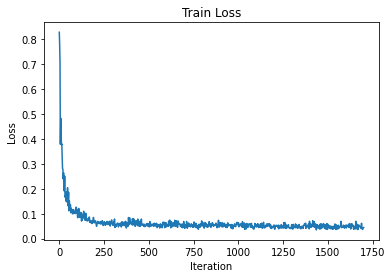

In [166]:
plt.plot(range(1, 1701, 2), loss_train)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Train Loss")

Text(0.5, 1.0, 'Test Loss')

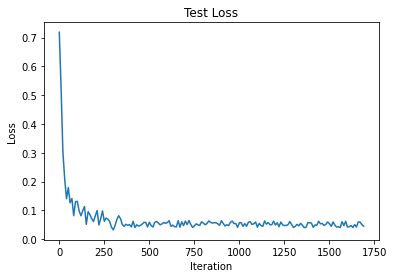

In [162]:
plt.plot(range(1, 1701, 10), loss_test)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Test Loss")

Part C

In [147]:
dataiter = iter(testloader)
with torch.no_grad():
      sample = dataiter.next()
      inputs_test, ground_truth_test = sample['image'], sample['ground_truth']
      outputs_test = net(inputs_test)

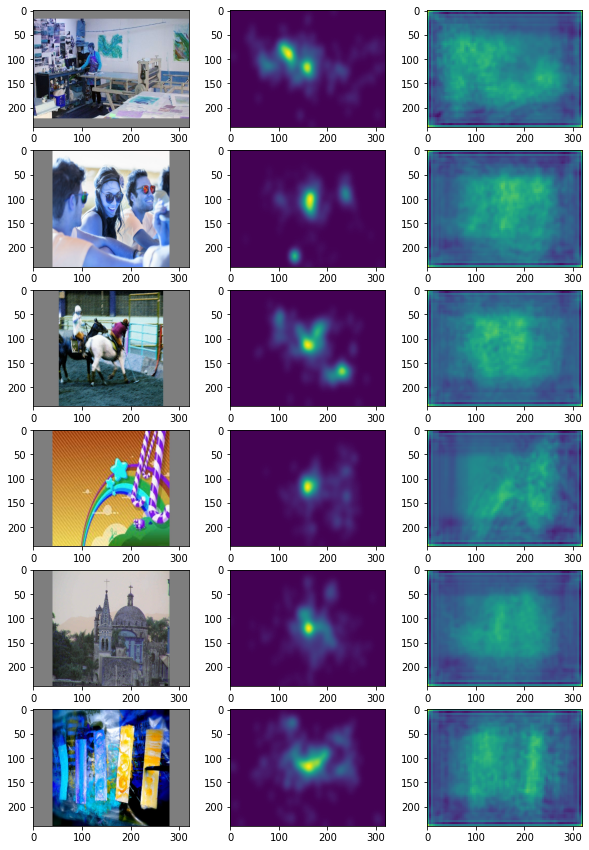

In [148]:
f, axarr = plt.subplots(6,3, figsize=(10, 15))

for i in range(6):
  img = inputs_test[i].numpy().transpose([1,2,0])
  gt = ground_truth_test[i].squeeze(0).numpy()
  pred = outputs_test[i].squeeze(0).numpy()
  axarr[i,0].imshow((img * 0.5) + 0.5)
  axarr[i,1].imshow(gt)
  axarr[i,2].imshow(pred)
